In [83]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, identity
from pylab import rcParams
rcParams['figure.figsize'] = 8,8

In [84]:
def init_lattice():
    lenx = 100
    leny = 100
    mx = np.zeros((leny,lenx))
    
    #_,axises = plt.subplots(4)
    
    small_house = [((0,0),(6,6))]
    L_house = [((0,0),(20,6)),((20,0),(26,10))]
    inv_L_house = [((0,0),(6,10)),((6,4),(26,10))]
    
    block_shape = (6+7+26,6+13+10)
    block_shifts = [(6, 23),
                    (6, 23+block_shape[1]+12),
                    (6+block_shape[0]+12, 23),
                    (6+block_shape[0]+12, 23+block_shape[1]+12)
                   ]
    def draw_block():
        block = np.zeros(block_shape)
        house_shifts = [(0,0),(26+7,10+13),(6+7,0),(0,6+13)]
        for s,(sy,sx) in zip([small_house, small_house, L_house, inv_L_house],
                        house_shifts):
            for fig in s:
                (yfrom,xfrom),(yto,xto) = fig
                block[sy+yfrom:sy+yto,sx+xfrom:sx+xto] = 1
        return block
    #for (sy,sx),ax in zip(block_shifts,axises):
    for (sy,sx) in block_shifts:
        t = draw_block()
        #print(t.shape)
        mx[sy:sy+block_shape[0], sx:sx+block_shape[1]] = t
        #ax.imshow(mx, cmap = 'gray')
    #plt.plot()
    return mx

In [85]:
mx = init_lattice()

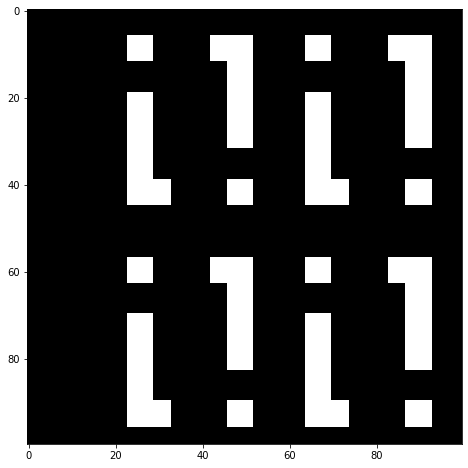

In [86]:
plt.imshow(mx,cmap = 'gray')

In [87]:
def write_video(video_frames):
    out = cv2.VideoWriter('gas_gas_gas.avi',cv2.VideoWriter_fourcc(*'XVID'), 60, (100, 100),isColor=False)
    for frame in video_frames:
        out.write(frame)
    out.release()
    

In [88]:
N_GRID = 100
N_VEC = N_GRID*N_GRID
l1, l2 = 1, 0
k = 0.5
h = 1
t = 0.25  # (tau must be <= 0.5 AND (between 0.0 and 1.0) -> tau range is between 0.0 and 0.0
coeffs = np.array([
    1-4*t*k/h**2,
    t*(k/h**2 - l1/(2*h)),
    t*(k/h**2 + l1/(2*h)),
    t*(k/h**2 - l2/(2*h)),
    t*(k/h**2 + l2/(2*h)),
])

In [89]:
gas_field = np.zeros((N_GRID,N_GRID))
gas_field[:,0] = 1.0
dx = [1, -1, 0, 0]
dy = [0, 0, 1, -1]
            

gas_vec = np.reshape(gas_field,(N_VEC,1))
A = lil_matrix((N_VEC,N_VEC))
b = np.zeros((N_VEC))
for i in range(100):
    A[i*N_GRID,i*N_GRID] = 1.0
    
for y in range(N_GRID):
    for x in range(1, N_GRID):
        
        vecidx = y*N_GRID+x
        A[vecidx,vecidx] = coeffs[0]
        
        for j in range(0, 4):
            x1 = x + dx[j]
            y1 = y + dy[j]
            coeff = coeffs[j+1]
            
            if x1>=N_GRID or y1>=N_GRID or y1 == 0 or mx[y1,x1]:
                A[vecidx,vecidx] += coeff
            else:
                A[vecidx,y1*N_GRID+x1] = coeff
# check
for i in range(N_VEC):
    if np.abs(np.sum(A[i,:])-1.0)>1e-6:
        print(f"Wrong in {i}: sum of coeffs {np.sum(A[i,:])}")

Break at 9092/30000
Tau = 0.25


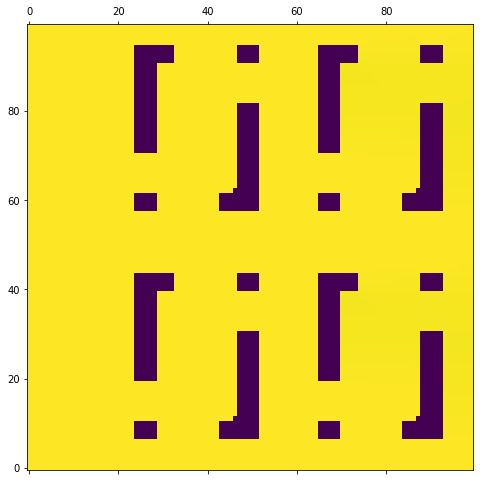

In [104]:
A = csr_matrix(A)
x = gas_vec
frames = []
steps = 30000
for i in range(steps):
    x_new = A * x
    frames.append(np.uint8((x_new**4*255).reshape((100,100))))
    error = np.max(np.abs(x_new - x))
    if error < 1e-5:
        print(f"Break at {i}/{steps}")
        print(f"Tau = {t}")
        break
    x = x_new
plt.matshow(x.reshape((100,100)))
plt.gca().invert_yaxis()
plt.show()

In [103]:
write_video(frames)